In [ ]:
"""
3/16/2021

Goal:
1. increase dataset
2. test model performance on completely new videos

** Add features based on eye-nose distance (cat face angle)
Logistic regression: .67, .717
Random forest: .47, .732
AdaBoost: .732, .79 ---------------------best!
Gradient Boost: .693, .719
XGBoost: .532, .682


"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

## Load data and create df
* .csv files already include both blurriness and face info (with more details)
* larger dataset(1832 rows)

In [2]:
bad = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare.csv')
good = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare.csv')
bad_0315 = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare_0315.csv')
good_0315 = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare_0315.csv')

In [3]:
len(bad),len(good),len(bad_0315),len(good_0315)

(808, 1024, 157, 141)

In [4]:
test_1 = pd.concat([bad,good],axis=0).reset_index(drop=True)
test_2 = pd.concat([bad_0315,good_0315],axis=0).reset_index(drop=True)
test = pd.concat([test_1,test_2],axis=0).reset_index(drop=True)
test

filename     lp_cat      lp_all  lp_ratio  \
0            IMG_0185.MOV_12.jpg   5.052993  151.810569  0.033285   
1           IMG_0185.MOV_156.jpg  12.748102   61.145684  0.208487   
2           IMG_0185.MOV_162.jpg  34.031338   53.224166  0.639396   
3           IMG_0185.MOV_168.jpg  35.830179   78.479448  0.456555   
4           IMG_0185.MOV_174.jpg  33.939300  125.446714  0.270548   
...                          ...        ...         ...       ...   
2125  Kittisaurus_6.mov_3080.jpg   3.851630   88.099325  0.043719   
2126  Kittisaurus_6.mov_7320.jpg   1.252839   32.453380  0.038604   
2127  Kittisaurus_6.mov_7336.jpg   1.416847   32.449710  0.043663   
2128  Kittisaurus_6.mov_7352.jpg   1.518716   36.611121  0.041482   
2129  Kittisaurus_6.mov_7400.jpg   2.796357   61.639306  0.045366   

      lp_cat_canny  lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x  \
0     13687.793353  20847.260510        0.656575     0  189.620674  0.638889   
1     10715.795177   6489.486205        1.651255     0  383.255789  0.224074   
2      5607.710122   2606.958020        2.151055     0  381.430203  0.291667   
3      7468.365741  11896.382691        0.627785     0  585.511742  0.120370   
4      7138.382092  26640.493901        0.267952     0  509.231774  0.105556   
...            ...           ...             ...   ...         ...       ...   
2125  10208.108950   3661.116603        2.788250     0  199.361481  0.593596   
2126  73839.305748   4315.132438       17.111713     0  173.216627  0.555419   
2127  62555.322840   3734.465773       16.750809     0  229.455878  0.594212   
2128  48379.752872   3609.038686       13.405163     0  226.291847  0.597291   
2129  24450.590820   4013.192684        6.092553     0   82.873397  0.492611   

         cat_y  face_size  size_ratio  \
0     0.439583      43681    0.021065   
1     0.374479     112896    0.054444   
2     0.339583     130321    0.062848   
3     0.282292     145924    0.070372   
4     0.354687     151321    0.072975   
...        ...        ...         ...   
2125  0.360991      94249    0.062538   
2126  0.340517       8100    0.005375   
2127  0.315733      11881    0.007883   
2128  0.325431      17424    0.011561   
2129  0.411638      57600    0.038220   

                                                   eyes  \
0                                                    []   
1                                  [(447, 819, 77, 95)]   
2              [(379, 758, 89, 95), (532, 757, 84, 89)]   
3             [(197, 643, 96, 108), (364, 658, 88, 90)]   
4                                [(180, 805, 105, 100)]   
...                                                 ...   
2125  [(1019, 427, 69, 59), (1143, 428, 66, 60), (63...   
2126                                                 []   
2127                                                 []   
2128          [(995, 339, 24, 23), (1054, 343, 31, 28)]   
2129           [(837, 448, 54, 45), (947, 459, 66, 45)]   

                       ears                                       nose  
0                        []                                         []  
1                        []                                         []  
2                        []                                         []  
3     [[72, 368, 163, 189]]                       [[288, 789, 74, 77]]  
4                        []                                         []  
...                     ...                                        ...  
2125  [[670, 304, 82, 131]]  [[1095, 518, 67, 46], [566, 603, 62, 36]]  
2126                     []                                         []  
2127                     []                                         []  
2128                     []                      [[1022, 372, 24, 19]]  
2129                     []                       [[889, 505, 46, 35]]  

[2130 rows x 16 columns]

In [5]:
import ast
# Convert to actual list and count number of eyes/ears/nose detected
test['eyes'] = test['eyes'].apply(lambda x: ast.literal_eval(x))
test['num_eye'] = test['eyes'].apply(lambda x: len(x))
test['ears'] = test['ears'].apply(lambda x: ast.literal_eval(x))
test['num_ear'] = test['ears'].apply(lambda x: len(x))
test['nose'] = test['nose'].apply(lambda x: ast.literal_eval(x))
test['num_nose'] = test['nose'].apply(lambda x: len(x))

In [6]:
test['eye_x1'] = test['eyes'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['eye_y1'] = test['eyes'].apply(lambda x: x[0][1] if (len(x)>0) else 0)
test['eye_w1'] = test['eyes'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['eye_x2'] = test['eyes'].apply(lambda x: x[1][0] if (len(x)>1) else 0)
test['eye_y2'] = test['eyes'].apply(lambda x: x[1][1] if (len(x)>1) else 0)
test['eye_w2'] = test['eyes'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['eye_w'] = test['eyes'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['eye_h1'] = test['eyes'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['eye_h2'] = test['eyes'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['eye_h'] = test['eyes'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['eye_size'] = test['eye_w']*test['eye_h']
test['eye_ratio'] = test['eye_size'] / test['face_size']

In [7]:
test['ear_w1'] = test['ears'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['ear_w2'] = test['ears'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['ear_w'] = test['ears'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['ear_h1'] = test['ears'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['ear_h2'] = test['ears'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['ear_h'] = test['ears'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

In [8]:
test['nose_x'] = test['nose'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['nose_y'] = test['nose'].apply(lambda x: x[0][1] if (len(x)>0) else 0)

In [9]:
# Add 'label' as the last column
# label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0]
label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0] + ['bad']*bad_0315.shape[0] + ['good']*good_0315.shape[0]
test['label'] = label_list
test.iloc[:,:]

filename     lp_cat      lp_all  lp_ratio  \
0            IMG_0185.MOV_12.jpg   5.052993  151.810569  0.033285   
1           IMG_0185.MOV_156.jpg  12.748102   61.145684  0.208487   
2           IMG_0185.MOV_162.jpg  34.031338   53.224166  0.639396   
3           IMG_0185.MOV_168.jpg  35.830179   78.479448  0.456555   
4           IMG_0185.MOV_174.jpg  33.939300  125.446714  0.270548   
...                          ...        ...         ...       ...   
2125  Kittisaurus_6.mov_3080.jpg   3.851630   88.099325  0.043719   
2126  Kittisaurus_6.mov_7320.jpg   1.252839   32.453380  0.038604   
2127  Kittisaurus_6.mov_7336.jpg   1.416847   32.449710  0.043663   
2128  Kittisaurus_6.mov_7352.jpg   1.518716   36.611121  0.041482   
2129  Kittisaurus_6.mov_7400.jpg   2.796357   61.639306  0.045366   

      lp_cat_canny  lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x  \
0     13687.793353  20847.260510        0.656575     0  189.620674  0.638889   
1     10715.795177   6489.486205        1.651255     0  383.255789  0.224074   
2      5607.710122   2606.958020        2.151055     0  381.430203  0.291667   
3      7468.365741  11896.382691        0.627785     0  585.511742  0.120370   
4      7138.382092  26640.493901        0.267952     0  509.231774  0.105556   
...            ...           ...             ...   ...         ...       ...   
2125  10208.108950   3661.116603        2.788250     0  199.361481  0.593596   
2126  73839.305748   4315.132438       17.111713     0  173.216627  0.555419   
2127  62555.322840   3734.465773       16.750809     0  229.455878  0.594212   
2128  48379.752872   3609.038686       13.405163     0  226.291847  0.597291   
2129  24450.590820   4013.192684        6.092553     0   82.873397  0.492611   

      ...  eye_ratio  ear_w1  ear_w2  ear_w ear_h1 ear_h2  ear_h  nose_x  \
0     ...   0.000000       0       0    0.0      0      0    0.0       0   
1     ...   0.064794       0       0    0.0      0      0    0.0       0   
2     ...   0.061065       0       0    0.0      0      0    0.0       0   
3     ...   0.062416     163       0  163.0    189      0  189.0     288   
4     ...   0.069389       0       0    0.0      0      0    0.0       0   
...   ...        ...     ...     ...    ...    ...    ...    ...     ...   
2125  ...   0.039808      82       0   82.0    131      0  131.0    1095   
2126  ...   0.000000       0       0    0.0      0      0    0.0       0   
2127  ...   0.000000       0       0    0.0      0      0    0.0       0   
2128  ...   0.040246       0       0    0.0      0      0    0.0    1022   
2129  ...   0.046875       0       0    0.0      0      0    0.0     889   

      nose_y  label  
0          0    bad  
1          0    bad  
2          0    bad  
3        789    bad  
4          0    bad  
...      ...    ...  
2125     518   good  
2126       0   good  
2127       0   good  
2128     372   good  
2129     505   good  

[2130 rows x 40 columns]

In [10]:
# Testing section
bad = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare.csv')
good = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare.csv')
bad_0315 = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare_0315.csv')
good_0315 = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare_0315.csv')
test_1 = pd.concat([bad,good],axis=0).reset_index(drop=True)
test_2 = pd.concat([bad_0315,good_0315],axis=0).reset_index(drop=True)
test = pd.concat([test_1,test_2],axis=0).reset_index(drop=True)

import ast
# Convert to actual list and count number of eyes/ears/nose detected
test['eyes'] = test['eyes'].apply(lambda x: ast.literal_eval(x))
test['num_eye'] = test['eyes'].apply(lambda x: len(x))
test['ears'] = test['ears'].apply(lambda x: ast.literal_eval(x))
test['num_ear'] = test['ears'].apply(lambda x: len(x))
test['nose'] = test['nose'].apply(lambda x: ast.literal_eval(x))
test['num_nose'] = test['nose'].apply(lambda x: len(x))

# eye position
test['eye_x1'] = test['eyes'].apply(lambda x: x[0][0] if (len(x)>0) else 100000)
test['eye_y1'] = test['eyes'].apply(lambda x: x[0][1] if (len(x)>0) else 100000)
test['eye_x2'] = test['eyes'].apply(lambda x: x[1][0] if (len(x)>1) else 100000)
test['eye_y2'] = test['eyes'].apply(lambda x: x[1][1] if (len(x)>1) else 100000)
# eye width
test['eye_w1'] = test['eyes'].apply(lambda x: x[0][2] if (len(x)>0) else 100000)
test['eye_w2'] = test['eyes'].apply(lambda x: x[1][2] if (len(x)>1) else 100000)
test['eye_w'] = test['eyes'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 100000)
# eye height
test['eye_h1'] = test['eyes'].apply(lambda x: x[0][3] if (len(x)>0) else 100000)
test['eye_h2'] = test['eyes'].apply(lambda x: x[1][3] if (len(x)>1) else 100000)
test['eye_h'] = test['eyes'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 100000)
# eye size and ratio compared to face
test['eye_size'] = test['eye_w']*test['eye_h']
test['eye_ratio'] = test['eye_size'] / test['face_size']

# nose position
test['nose_x'] = test['nose'].apply(lambda x: x[0][0] if (len(x)>0) else 100000)
test['nose_y'] = test['nose'].apply(lambda x: x[0][1] if (len(x)>0) else 100000)

# ear width
test['ear_w1'] = test['ears'].apply(lambda x: x[0][2] if (len(x)>0) else 100000)
test['ear_w2'] = test['ears'].apply(lambda x: x[1][2] if (len(x)>1) else 100000)
test['ear_w'] = test['ears'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 100000)
# ear height
test['ear_h1'] = test['ears'].apply(lambda x: x[0][3] if (len(x)>0) else 100000)
test['ear_h2'] = test['ears'].apply(lambda x: x[1][3] if (len(x)>1) else 100000)
test['ear_h'] = test['ears'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 100000)


# Generate features to address face angle
test['en_x1'] = abs(test['eye_x1'] - test['nose_x'])
test['en_x2'] = abs(test['eye_x2'] - test['nose_y'])
test['en_x_delta'] = abs(test['en_x1'] - test['en_x2'])
test['angle_x'] = test['en_x_delta'].apply(lambda x: 0 if x>90000 else 1)

test['en_y1'] = abs(test['eye_y1'] - test['nose_x'])
test['en_y2'] = abs(test['eye_y2'] - test['nose_y'])
test['en_y_delta'] = abs(test['en_y1'] - test['en_y2'])
test['angle_y'] = test['en_y_delta'].apply(lambda x: 0 if x>90000 else 1)

pd.set_option('display.max_columns', None)

# Add 'label' as the last column
label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0] + ['bad']*bad_0315.shape[0] + ['good']*good_0315.shape[0]
test['label'] = label_list
test.drop(columns=['eyes','ears','nose']).iloc[:,:]

filename     lp_cat      lp_all  lp_ratio  \
0            IMG_0185.MOV_12.jpg   5.052993  151.810569  0.033285   
1           IMG_0185.MOV_156.jpg  12.748102   61.145684  0.208487   
2           IMG_0185.MOV_162.jpg  34.031338   53.224166  0.639396   
3           IMG_0185.MOV_168.jpg  35.830179   78.479448  0.456555   
4           IMG_0185.MOV_174.jpg  33.939300  125.446714  0.270548   
...                          ...        ...         ...       ...   
2125  Kittisaurus_6.mov_3080.jpg   3.851630   88.099325  0.043719   
2126  Kittisaurus_6.mov_7320.jpg   1.252839   32.453380  0.038604   
2127  Kittisaurus_6.mov_7336.jpg   1.416847   32.449710  0.043663   
2128  Kittisaurus_6.mov_7352.jpg   1.518716   36.611121  0.041482   
2129  Kittisaurus_6.mov_7400.jpg   2.796357   61.639306  0.045366   

      lp_cat_canny  lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x  \
0     13687.793353  20847.260510        0.656575     0  189.620674  0.638889   
1     10715.795177   6489.486205        1.651255     0  383.255789  0.224074   
2      5607.710122   2606.958020        2.151055     0  381.430203  0.291667   
3      7468.365741  11896.382691        0.627785     0  585.511742  0.120370   
4      7138.382092  26640.493901        0.267952     0  509.231774  0.105556   
...            ...           ...             ...   ...         ...       ...   
2125  10208.108950   3661.116603        2.788250     0  199.361481  0.593596   
2126  73839.305748   4315.132438       17.111713     0  173.216627  0.555419   
2127  62555.322840   3734.465773       16.750809     0  229.455878  0.594212   
2128  48379.752872   3609.038686       13.405163     0  226.291847  0.597291   
2129  24450.590820   4013.192684        6.092553     0   82.873397  0.492611   

         cat_y  face_size  size_ratio  num_eye  num_ear  num_nose  eye_x1  \
0     0.439583      43681    0.021065        0        0         0  100000   
1     0.374479     112896    0.054444        1        0         0     447   
2     0.339583     130321    0.062848        2        0         0     379   
3     0.282292     145924    0.070372        2        1         1     197   
4     0.354687     151321    0.072975        1        0         0     180   
...        ...        ...         ...      ...      ...       ...     ...   
2125  0.360991      94249    0.062538        4        1         2    1019   
2126  0.340517       8100    0.005375        0        0         0  100000   
2127  0.315733      11881    0.007883        0        0         0  100000   
2128  0.325431      17424    0.011561        2        0         1     995   
2129  0.411638      57600    0.038220        2        0         1     837   

      eye_y1  eye_x2  eye_y2  eye_w1  eye_w2     eye_w  eye_h1  eye_h2  \
0     100000  100000  100000  100000  100000  100000.0  100000  100000   
1        819  100000  100000      77  100000      77.0      95  100000   
2        758     532     757      89      84      86.5      95      89   
3        643     364     658      96      88      92.0     108      90   
4        805  100000  100000     105  100000     105.0     100  100000   
...      ...     ...     ...     ...     ...       ...     ...     ...   
2125     427    1143     428      69      66      72.5      59      60   
2126  100000  100000  100000  100000  100000  100000.0  100000  100000   
2127  100000  100000  100000  100000  100000  100000.0  100000  100000   
2128     339    1054     343      24      31      27.5      23      28   
2129     448     947     459      54      66      60.0      45      45   

          eye_h      eye_size     eye_ratio  nose_x  nose_y  ear_w1  ear_w2  \
0     100000.00  1.000000e+10  2.289325e+05  100000  100000  100000  100000   
1         95.00  7.315000e+03  6.479415e-02  100000  100000  100000  100000   
2         92.00  7.958000e+03  6.106460e-02  100000  100000  100000  100000   
3         99.00  9.108000e+03  6.241605e-02     288     789     163  100000   
4        100.00  1.050000

### A. Conventional train test split

In [11]:
# df = test.copy()
# # Train test split
# X = df.iloc[:,:-1]

# mapping = {'bad':0, 'good':1}
# y = df['label'].map(mapping)

# X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

### B. Proper train test split

In [12]:
# Make sure all the frames in test set are from videos not seen in training set
# Test set size: ~367 frames
df = test.copy()
df.head(370)

filename     lp_cat      lp_all  lp_ratio  lp_cat_canny  \
0     IMG_0185.MOV_12.jpg   5.052993  151.810569  0.033285  13687.793353   
1    IMG_0185.MOV_156.jpg  12.748102   61.145684  0.208487  10715.795177   
2    IMG_0185.MOV_162.jpg  34.031338   53.224166  0.639396   5607.710122   
3    IMG_0185.MOV_168.jpg  35.830179   78.479448  0.456555   7468.365741   
4    IMG_0185.MOV_174.jpg  33.939300  125.446714  0.270548   7138.382092   
..                    ...        ...         ...       ...           ...   
365  IMG_8976.MOV_738.jpg   0.962615  151.081632  0.006371  48631.284899   
366  IMG_8976.MOV_741.jpg   1.034143  237.888215  0.004347  67798.116109   
367  IMG_8976.MOV_744.jpg   0.693148  467.889270  0.001481  44918.992695   
368  IMG_8976.MOV_747.jpg   1.013045  366.593430  0.002763  65764.920556   
369  IMG_8976.MOV_750.jpg   1.001304  441.297709  0.002269  65875.934997   

     lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x     cat_y  \
0    20847.260510        0.656575     0  189.620674  0.638889  0.439583   
1     6489.486205        1.651255     0  383.255789  0.224074  0.374479   
2     2606.958020        2.151055     0  381.430203  0.291667  0.339583   
3    11896.382691        0.627785     0  585.511742  0.120370  0.282292   
4    26640.493901        0.267952     0  509.231774  0.105556  0.354687   
..            ...             ...   ...         ...       ...       ...   
365  27927.698068        1.741328     1  499.609848  0.713889  0.269271   
366  50547.843436        1.341266     1  491.382743  0.718519  0.275521   
367  76978.831429        0.583524     1  400.249922  0.650000  0.309375   
368  70977.628517        0.926558     1  475.063154  0.715741  0.284375   
369  78993.051003        0.833946     1  468.363107  0.712963  0.287500   

     face_size  size_ratio                                       eyes  \
0        43681    0.021065                                         []   
1       112896    0.054444                       [(447, 819, 77, 95)]   
2       130321    0.062848   [(379, 758, 89, 95), (532, 757, 84, 89)]   
3       145924    0.070372  [(197, 643, 96, 108), (364, 658, 88, 90)]   
4       151321    0.072975                     [(180, 805, 105, 100)]   
..         ...         ...                                        ...   
365       2809    0.001355                                         []   
366       2601    0.001254                                         []   
367       2601    0.001254                                         []   
368       2704    0.001304                                         []   
369       2809    0.001355                                         []   

                      ears                  nose  num_eye  num_ear  num_nose  \
0                       []                    []        0        0         0   
1                       []                    []        1        0         0   
2                       []                    []        2        0         0   
3    [[72, 368, 163, 189]]  [[288, 789, 74, 77]]        2        1         1   
4                       []                    []        1        0         0   
..                     ...                   ...      ...      ...       ...   
365                     []                    []        0        0         0   
366                     []                    []        0        0         0   
367                     []                    []        0        0         0   
368                     []                    []        0        0         0   
369                     []                    []        0        0         0   

     eye_x1  eye_y1  eye_x2  eye_y2  eye_w1  eye_w2     eye_w  eye_h1  eye_h2  \
0    100000  100000  100000  100000  100000  100000  100000.0  100000  100000   
1       447     819  100000  100000      77  100000      77.0      95  100000   
2       379     758     532     757      89      84      86.5      95      89   
3       197     643     364     658      

In [13]:
df['video'] = df['filename'].apply(lambda x: x.split('.M')[0])

In [14]:
# Use frames from 12 videos as test set
test_video = df.groupby('video').count().iloc[5:25,:].index.tolist()
len(test_video)

20

In [15]:
# Separate features and target
X = df.iloc[:,:-2]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)


# Manual tran test split
X_train_df = df[~df.video.isin(test_video)].iloc[:,:-2]
X_test_df = df[df.video.isin(test_video)].iloc[:,:-2]

y_train = df[~df.video.isin(test_video)]['label'].map(mapping)
y_test = df[df.video.isin(test_video)]['label'].map(mapping)

In [16]:
len(X_train_df),len(X_test_df)

(1752, 378)

### Reset train_df and test_df index

In [17]:
# Reset index
X_train_df.reset_index(inplace=True,drop=True)
X_test_df.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [18]:
X_test_df

filename     lp_cat     lp_all  lp_ratio  lp_cat_canny  \
0         IMG_0244.MOV_102.jpg   3.333790  45.885335  0.072655  46522.241295   
1          IMG_0244.MOV_12.jpg   3.514132  37.402837  0.093954  33220.659186   
2         IMG_0244.MOV_126.jpg   2.283406  55.440300  0.041187  55918.971478   
3         IMG_0244.MOV_138.jpg   5.472748  46.623188  0.117383  35320.538793   
4         IMG_0244.MOV_144.jpg   7.470287  50.419801  0.148162  25321.767219   
..                         ...        ...        ...       ...           ...   
373  IMG_5179.TRIM.MOV_207.jpg  43.083811  78.686023  0.547541  20952.909760   
374   IMG_5179.TRIM.MOV_21.jpg  16.015831  57.668625  0.277722  17523.835461   
375  IMG_5179.TRIM.MOV_210.jpg  16.278677  64.029280  0.254238  17106.770542   
376  IMG_5179.TRIM.MOV_213.jpg  16.201971  66.602421  0.243264  26436.602048   
377  IMG_5179.TRIM.MOV_219.jpg  42.200079  77.322895  0.545764  24804.392713   

     lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x     cat_y  \
0     4712.744573        9.871581     0  390.128184  0.490741  0.296875   
1     2355.651042       14.102538     0  512.410968  0.535185  0.233854   
2     5337.374674       10.476868     0  176.366097  0.433333  0.416146   
3     3091.823343       11.423854     0  303.077548  0.392593  0.354167   
4     3075.266059        8.234009     0  401.808412  0.393519  0.299479   
..            ...             ...   ...         ...       ...       ...   
373   5088.889865        4.117383     0  498.902796  0.472222  0.240625   
374   3199.383030        5.477255     0  774.052324  0.216667  0.129688   
375   3612.625430        4.735274     0  481.004158  0.501852  0.249479   
376   4244.812934        6.227978     0  503.048705  0.506481  0.238021   
377   5423.641927        4.573383     0  527.079690  0.432407  0.228125   

     face_size  size_ratio                                               eyes  \
0        19881    0.009588                                                 []   
1        25921    0.012500                                                 []   
2        15625    0.007535                                                 []   
3        44944    0.021674                               [(476, 728, 37, 61)]   
4        61009    0.029422                               [(567, 646, 89, 68)]   
..         ...         ...                                                ...   
373     145924    0.070372  [(571, 582, 94, 74), (742, 587, 100, 66), (400...   
374     103041    0.049692  [(294, 352, 72, 72), (430, 346, 109, 63), (256...   
375     110224    0.053156  [(588, 583, 83, 65), (750, 587, 95, 68), (393,...   
376     119716    0.057733  [(590, 564, 101, 71), (761, 569, 91, 73), (377...   
377     151321    0.072975          [(530, 538, 97, 82), (700, 567, 108, 78)]   

                                                  ears  \
0                                 [[656, 489, 79, 97]]   
1                                                   []   
2                               [[582, 731, 102, 109]]   
3                                                   []   
4                                                   []   
..                                                 ...   
373       [[399, 283, 228, 202], [813, 288, 218, 212]]   
374  [[579, 124, 183, 226], [529, 446, 209, 236], [...   
375  [[427, 242, 208, 233], [804, 297, 251, 218], [...   
376       [[444, 245, 201, 220], [808, 271, 257, 182]]   
377       [[382, 194, 224, 248], [805, 283, 232, 238]]   

                                         nose  num_eye  num_ear  num_nose  \
0                        [[561, 663, 54, 24]]        0        1         1   
1                        [[630, 551, 47, 32]]        0        0         1   
2                                          []        0        1         0   
3                        [[495, 810, 44, 44]]        1        0         1   
4                        [[501, 723, 65, 62]]        1        0         1   
..                          

In [19]:
X_test_df.columns

Index(['filename', 'lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny',
       'lp_all_canny', 'lp_ratio_canny', 'blur', 'to_ctr', 'cat_x', 'cat_y',
       'face_size', 'size_ratio', 'eyes', 'ears', 'nose', 'num_eye', 'num_ear',
       'num_nose', 'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2', 'eye_w1', 'eye_w2',
       'eye_w', 'eye_h1', 'eye_h2', 'eye_h', 'eye_size', 'eye_ratio', 'nose_x',
       'nose_y', 'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
       'en_x1', 'en_x2', 'en_x_delta', 'angle_x', 'en_y1', 'en_y2',
       'en_y_delta', 'angle_y'],
      dtype='object')

In [20]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        378 non-null    object 
 1   lp_cat          378 non-null    float64
 2   lp_all          378 non-null    float64
 3   lp_ratio        378 non-null    float64
 4   lp_cat_canny    378 non-null    float64
 5   lp_all_canny    378 non-null    float64
 6   lp_ratio_canny  378 non-null    float64
 7   blur            378 non-null    int64  
 8   to_ctr          378 non-null    float64
 9   cat_x           378 non-null    float64
 10  cat_y           378 non-null    float64
 11  face_size       378 non-null    int64  
 12  size_ratio      378 non-null    float64
 13  eyes            378 non-null    object 
 14  ears            378 non-null    object 
 15  nose            378 non-null    object 
 16  num_eye         378 non-null    int64  
 17  num_ear         378 non-null    int

In [21]:
y_test

0      0
1      0
2      0
3      0
4      0
      ..
373    1
374    1
375    1
376    1
377    1
Name: label, Length: 378, dtype: int64

## Scale continuous variables

In [22]:
headers = ['filename','lp_cat','lp_all','lp_ratio','lp_cat_canny','lp_all_canny','lp_ratio_canny','blur',\
               'to_ctr','cat_x','cat_y','face_size','size_ratio',\
               'eyes','ears','nose']

In [23]:
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio','lp_all_canny',
            'lp_cat_canny', 
            'lp_ratio_canny',\
#             'cat_x', 'cat_y',
            'face_size', 'size_ratio', 'to_ctr',\
            'num_eye','num_ear', 'num_nose', 
            'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2', 'eye_h',
            'eye_size', 'eye_ratio',
            'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
            'en_x1','en_x2','en_y1','en_y2',
            'en_x_delta', 'en_y_delta',
#             'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2',
#             'nose_x'
           ]
X_train_con = X_train_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_df[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)
# X_train_con_df

In [24]:
# Try without 'blur'
X_train = X_train_con_df

In [25]:
# # Combine Con and Cat
# X_train = pd.concat([X_train_con_df,X_train_df[['blur']]], axis='columns')
# X_train

In [26]:
# Repeat for test set
# Continuous variables
# features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr']
X_test_con = X_test_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_df[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# Combine Con and Cat
X_test = pd.concat([X_test_con_df,X_test_df[['blur']]], axis='columns')
X_test

lp_cat    lp_all  lp_ratio  lp_all_canny  lp_cat_canny  lp_ratio_canny  \
0   -0.359861 -1.181047 -0.336489     -0.520991      1.161490        2.104712   
1   -0.356505 -1.390313 -0.291917     -0.713460      0.504404        3.452206   
2   -0.379409 -0.945324 -0.402341     -0.469987      1.625680        2.297487   
3   -0.320055 -1.162844 -0.242888     -0.653348      0.608136        2.599087   
4   -0.282880 -1.069181 -0.178476     -0.654700      0.114207        1.583171   
..        ...       ...       ...           ...           ...             ...   
373  0.379896 -0.371846  0.657297     -0.490277     -0.101611        0.272090   
374 -0.123845 -0.890351  0.092651     -0.644565     -0.271004        0.705188   
375 -0.118954 -0.733432  0.043507     -0.610822     -0.291606        0.468879   
376 -0.120381 -0.669952  0.020542     -0.559200      0.169278        0.944282   
377  0.363449 -0.405475  0.653580     -0.462943      0.088649        0.417319   

     face_size  size_ratio    to_ctr   num_eye   num_ear  num_nose    eye_w1  \
0    -1.190193   -1.190193 -0.475935 -2.342073 -0.502365  0.098465  3.180823   
1    -1.128929   -1.128929  0.262055 -2.342073 -1.512439  0.098465  3.180823   
2    -1.233362   -1.233362 -1.766012 -2.342073 -0.502365 -2.560081  3.180823   
3    -0.935977   -0.935977 -1.001295 -1.079158 -1.512439  0.098465 -0.316168   
4    -0.773028   -0.773028 -0.405444 -1.079158 -1.512439  0.098465 -0.314349   
..         ...         ...       ...       ...       ...       ...       ...   
373   0.088271    0.088271  0.180531  1.446673  0.507709  2.757011 -0.314174   
374  -0.346694   -0.346694  1.841088  2.709588  1.517784  2.757011 -0.314943   
375  -0.273837   -0.273837  0.072511  1.446673  1.517784  0.098465 -0.314559   
376  -0.177559   -0.177559  0.205552  1.446673  0.507709  0.098465 -0.313929   
377   0.143013    0.143013  0.350582  0.183757  0.507709 -2.560081 -0.314069   

       eye_w2     eye_w    eye_h1    eye_h2     eye_h  eye_size  eye_ratio  \
0    2.135140  3.180823  3.180824  2.135140  3.180824  3.180825   3.178324   
1    2.135140  3.180823  3.180824  2.135140  3.180824  3.180825   2.390152   
2    2.135140  3.180823  3.180824  2.135140  3.180824  3.180825   4.099659   
3    2.135140 -0.316235 -0.315112  2.135140 -0.315086 -0.314386  -0.204162   
4    2.135140 -0.314416 -0.314867  2.135140 -0.314842 -0.314385  -0.204162   
..        ...       ...       ...       ...       ...       ...        ...   
373 -0.468215 -0.314229 -0.314657 -0.468764 -0.314842 -0.314384  -0.204162   
374 -0.467981 -0.314311 -0.314727 -0.468842 -0.314404 -0.314384  -0.204162   
375 -0.468346 -0.314276 -0.314972 -0.468712 -0.314818 -0.314384  -0.204162   
376 -0.468450 -0.314008 -0.314762 -0.468582 -0.314667 -0.314384  -0.204162   
377 -0.468007 -0.313944 -0.314378 -0.468451 -0.314422 -0.314384  -0.204162   

       ear_w1    ear_w2     ear_w    ear_h1    ear_h2     ear_h     en_x1  \
0   -0.491549  1.130092 -0.491684 -0.491158  1.130092 -0.491162  3.842922   
1    2.044034  1.130092  2.044034  2.044034  1.130092  2.044034  3.840072   
2   -0.490965  1.130092 -0.491100 -0.490854  1.130092 -0.490857 -0.263617   
3    2.044034  1.130092  2.044034  2.044034  1.130092  2.044034 -0.262833   
4    2.044034  1.130092  2.044034  2.044034  1.130092  2.044034 -0.260892   
..        ...       ...       ...       ...       ...       ...       ...   
373 -0.487768 -0.884280 -0.488030 -0.488494 -0.884237 -0.488370 -0.260148   
374 -0.488910 -0.884461 -0.489273 -0.487885 -0.883753 -0.488726 -0.261924   
375 -0.488275 -0.883613 -0.488850 -0.487707 -0.884116 -0.488768 -0.251311   
376 -0.488453 -0.883492 -0.487877 -0.488037 -0.884843 -0.488523 -0.251269   
377 -0.487869 -0.883997 -0.487903 -0.487326 -0.883712 -0.487457  3.844202   

        en_x2     en_y1     en_y2  en_x_delta  en_y_delta  blur  
0    2.621707  3.842081  2.621425   -0.325054   -0.324793     0  
1    2.625109  3.839221  2.624815   -0.325867   -0.325607     0  
2   -0.395913

In [27]:
# Try without 'blur'
X_test = X_test_con_df

## 1. Logistic regression

### A. Basic

In [28]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  0.0696


Feature                    Coef
16          eye_h2    [246.26075918469226]
20          ear_w1     [234.2671141068716]
18        eye_size    [198.55528999499958]
12          eye_w1     [197.8010709639919]
23          ear_h1    [136.12059131840186]
31      en_y_delta     [60.29359264780646]
24          ear_h2    [40.715759453895494]
29           en_y2     [39.80342463097654]
28           en_y1    [23.086381573341242]
4     lp_cat_canny     [1.714589637600748]
7       size_ratio    [1.1293037557875643]
10         num_ear    [0.9173704474074037]
0           lp_cat    [0.8893319801817546]
1           lp_all  [0.021073834479880475]
11        num_nose  [0.000758807296573134]
5   lp_ratio_canny   [-0.1218384832018657]
9          num_eye  [-0.45001705301267436]
6        face_size  [-0.45479313552651773]
2         lp_ratio    [-0.551871672940512]
3     lp_all_canny   [-0.5715826108352189]
8           to_ctr   [-0.8184959319001445]
19       eye_ratio   [-1.0216912235334337]
26           en_x1   [-23.812192828116512]
27           en_x2    [-39.14667258643549]
21          ear_w2    [-40.05519721825992]
30      en_x_delta   [-55.115800595806526]
15          eye_h1    [-93.02215564469245]
14           eye_w   [-115.26684491946465]
22           ear_w   [-164.45410038837684]
17           eye_h    [-180.4299432936617]
25           ear_h   [-205.70245706309862]
13          eye_w2    [-256.0970948595807]

In [29]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)               100                78
Good (1)               45               155

In [30]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion/np.sum(fraud_confusion), cmap=plt.cm.Blues,
           annot=True, square=True, fmt='.2%',
           xticklabels=['Bad', 'Good'],
           yticklabels=['Bad', 'Good']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [31]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [32]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.6746031746031746 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.69      0.56      0.62       178
           1       0.67      0.78      0.72       200

    accuracy                           0.67       378
   macro avg       0.68      0.67      0.67       378
weighted avg       0.68      0.67      0.67       378



In [33]:
# Define plot_roc function
def plot_roc(model_name,model):
    y_scores = model.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC of '+ model_name)
    plt.show()

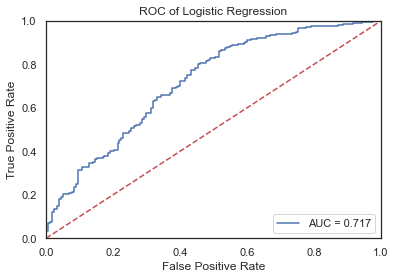

In [34]:
# Logistic regression ROC curve
plot_roc('Logistic Regression', lm)

### B. Hyperparameter Tuning

In [35]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [36]:
# note that train and validation sets are not split properly!

In [37]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805176 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [38]:
# Use best model on test set
lm_best = grid_result.estimator
lm_best.fit(X_train,y_train)
y_predict = lm_best.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)               106                72
Good (1)               49               151

In [39]:
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm_best.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False).head(5)

intercept:  0.0696


Feature                  Coef
4   lp_cat_canny   [1.607175955663585]
7     size_ratio  [1.0455977377507961]
10       num_ear  [0.8746396228939011]
0         lp_cat  [0.7942907597918801]
29         en_y2    [0.28767780555622]

In [40]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.6798941798941799 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.68      0.60      0.64       178
           1       0.68      0.76      0.71       200

    accuracy                           0.68       378
   macro avg       0.68      0.68      0.68       378
weighted avg       0.68      0.68      0.68       378



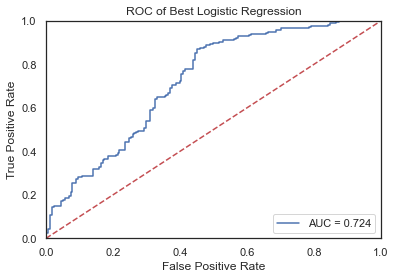

In [41]:
# Logistic regression ROC curve
plot_roc('Best Logistic Regression', lm_best)

In [42]:
# Only small improvement compared to the basic model!

## 2. Random Forests

### A. Basic

In [43]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [44]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
randomforest = RandomForestClassifier(n_estimators=200)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.473015873015873

In [45]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

Accuracy score: 0.47883597883597884 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.47      1.00      0.64       178
           1       1.00      0.01      0.03       200

    accuracy                           0.48       378
   macro avg       0.74      0.51      0.34       378
weighted avg       0.75      0.48      0.32       378



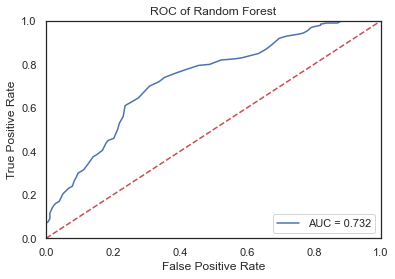

In [46]:
# Random Forest ROC curve
plot_roc('Random Forest', randomforest)

In [47]:
interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [48]:
# y_scores

### B. Hyperparameter Tuning
The most important parameter is the number of random features to sample at each split point (max_features).  Another important parameter for random forest is the number of trees (n_estimators). Ideally, this should be increased until no further improvement is seen in the model.

In [49]:
# # define models and parameters
# model = RandomForestClassifier()
# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']
# # define grid search
# grid = dict(n_estimators=n_estimators,max_features=max_features)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)

In [50]:
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# # for mean, stdev, param in zip(means, stds, params):
# #     print("%f (%f) with: %r" % (mean, stdev, param))

In [51]:
# # Use best model on test set
# rf_best = grid_result.estimator
# rf_best.fit(X_train,y_train)
# y_predict = rf_best.predict(X_test)
# pd.DataFrame(confusion_matrix(y_test, y_predict),\
#              columns=['Predict-Bad (0)','Predict-Good (1)'],\
#             index=['Bad (0)','Good (1)'])

In [52]:
# pred = randomforest.predict(X_test)
# print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
# print('Classification report (Random Forests):\n\n',classification_report(y_test,y_predict))

In [53]:
# # Random Forests ROC curve
# y_scores = rf_best.predict_proba(X_test)
# fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.title('ROC of Random Forests')
# plt.show()

In [54]:
# Not necessarily better

### C. Feature importatnce

In [55]:
pd.DataFrame(list(zip(X_train.columns,np.transpose(randomforest.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

Feature      Coef
4     lp_cat_canny  0.099659
13          eye_w2  0.062811
1           lp_all  0.058397
5   lp_ratio_canny  0.053494
16          eye_h2  0.051078
3     lp_all_canny  0.049153
19       eye_ratio  0.041217
8           to_ctr  0.034683
17           eye_h  0.034613
7       size_ratio  0.034500
0           lp_cat  0.034099
12          eye_w1  0.033820
15          eye_h1  0.033810
27           en_x2  0.033621
6        face_size  0.033421
29           en_y2  0.031278
9          num_eye  0.029701
2         lp_ratio  0.026717
26           en_x1  0.026171
14           eye_w  0.026160
31      en_y_delta  0.022503
22           ear_w  0.021143
30      en_x_delta  0.020753
28           en_y1  0.020484
20          ear_w1  0.017166
18        eye_size  0.016283
25           ear_h  0.013804
21          ear_w2  0.011402
23          ear_h1  0.011022
24          ear_h2  0.008987
10         num_ear  0.006069
11        num_nose  0.001981

In [56]:
# Logistic regression has higher AUC score
# But Random forest has better precision

## 3. AdaBoost

In [57]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(X_train,y_train);

In [58]:
pred = ada.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,ada.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (AdaBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7328042328042328
ROC AUC score: 0.7898735955056179 

Classification report (AdaBoost):

               precision    recall  f1-score   support

           0       0.74      0.66      0.70       178
           1       0.73      0.80      0.76       200

    accuracy                           0.73       378
   macro avg       0.73      0.73      0.73       378
weighted avg       0.73      0.73      0.73       378



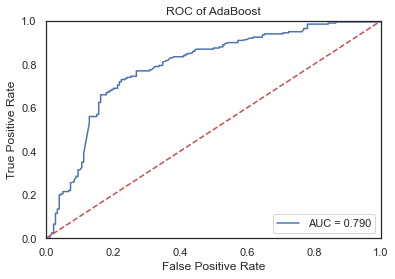

In [59]:
# AdaBoost ROC curve
plot_roc('AdaBoost', ada)

## 4. Gradient Boost

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

In [61]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(X_train, y_train)

In [62]:
pred = gb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,gb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6931216931216931
ROC AUC score: 0.718679775280899 

Classification report (XGBoost):

               precision    recall  f1-score   support

           0       0.78      0.49      0.60       178
           1       0.66      0.88      0.75       200

    accuracy                           0.69       378
   macro avg       0.72      0.68      0.68       378
weighted avg       0.71      0.69      0.68       378



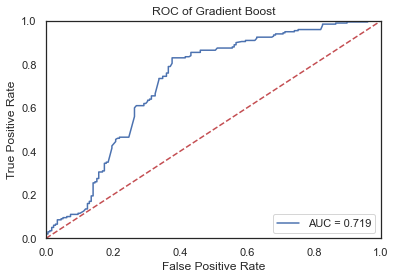

In [63]:
# Gradient Boost ROC curve
plot_roc('Gradient Boost', gb)

## 5. XGBoost

In [64]:
X_train.columns
# X_train.columns[X_train.columns.duplicated()]

Index(['lp_cat', 'lp_all', 'lp_ratio', 'lp_all_canny', 'lp_cat_canny',
       'lp_ratio_canny', 'face_size', 'size_ratio', 'to_ctr', 'num_eye',
       'num_ear', 'num_nose', 'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2',
       'eye_h', 'eye_size', 'eye_ratio', 'ear_w1', 'ear_w2', 'ear_w', 'ear_h1',
       'ear_h2', 'ear_h', 'en_x1', 'en_x2', 'en_y1', 'en_y2', 'en_x_delta',
       'en_y_delta'],
      dtype='object')

In [65]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train);

In [66]:
pred = xgb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.5317460317460317
ROC AUC score: 0.6819382022471911 

Classification report (XGBoost):

               precision    recall  f1-score   support

           0       0.50      0.98      0.66       178
           1       0.87      0.14      0.23       200

    accuracy                           0.53       378
   macro avg       0.69      0.56      0.45       378
weighted avg       0.70      0.53      0.44       378



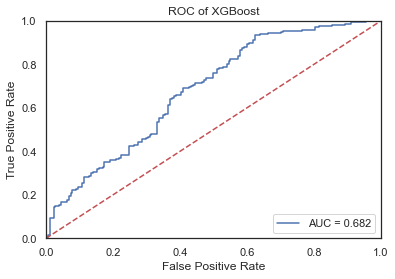

In [67]:
# XGBoost ROC curve
plot_roc('XGBoost', xgb)

## Examine model results

### 1. Check the best frame for each video file

In [68]:
# Specify the model to check
model = lm_best
# model = randomforest
model = gb
# model = xgb
model = ada

In [69]:
test_df = df[df.video.isin(test_video)].reset_index(drop=True)
# [['video','filename','label']]

threshold = 0.56
y_predict = (model.predict_proba(X_test)[:, 1] >= threshold).tolist()
test_df['label'] = y_test
test_df['pred'] = [0 if x==False else 1 for x in y_predict]
test_df['prob'] = model.predict_proba(X_test)[:, 1]

In [70]:
# test_df

In [71]:
test_df['prob_max'] = test_df.groupby(['video'])['prob'].transform(max)

In [72]:
pd.set_option('display.max_columns', None)
test_df[test_df.video=="IMG_0250"].drop(columns=['eyes','ears','nose','video']).sort_values('prob',ascending=False)

filename    lp_cat     lp_all  lp_ratio  lp_cat_canny  \
46   IMG_0250.MOV_96.jpg  2.584052  62.793635  0.041151   9252.833564   
45   IMG_0250.MOV_48.jpg  4.788617  86.128341  0.055599   8456.846024   
225  IMG_0250.MOV_90.jpg  2.299438  60.943188  0.037731  18825.630821   
44   IMG_0250.MOV_42.jpg  4.549719  86.296910  0.052722   7662.382242   

     lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x     cat_y  \
46     772.297309       11.980922     0  209.403916  0.463021  0.317593   
45    1972.199218        4.288028     0  489.800980  0.358854  0.122222   
225   5314.326158        3.542430     0  203.273215  0.476042  0.316667   
44    4892.083875        1.566282     0  473.776319  0.339583  0.166667   

     face_size  size_ratio  num_eye  num_ear  num_nose  eye_x1  eye_y1  \
46       78961    0.038079        0        0         1  100000  100000   
45      219024    0.105625        2        2         1     783     230   
225      67081    0.032350        2        1         1     940     376   
44      211600    0.102045        2        2         1     703     283   

     eye_x2  eye_y2  eye_w1  eye_w2     eye_w  eye_h1  eye_h2     eye_h  \
46   100000  100000  100000  100000  100000.0  100000  100000  100000.0   
45      983     294     109     114     111.5     107      94     100.5   
225    1059     426      72      55      63.5      85      70      77.5   
44      937     354     138     113     125.5     124      91     107.5   

         eye_size      eye_ratio  nose_x  nose_y  ear_w1  ear_w2     ear_w  \
46   1.000000e+10  126644.799331    1015     524  100000  100000  100000.0   
45   1.120575e+04       0.051162     858     395     113     175     144.0   
225  4.921250e+03       0.073363    1019     512     143  100000     143.0   
44   1.349125e+04       0.063758     807     469     148     211     179.5   

     ear_h1  ear_h2     ear_h  en_x1  en_x2  en_x_delta  angle_x  en_y1  \
46   100000  100000  100000.0  98985  99476         491        1  98985   
45      141     247     194.0     75    588         513        1    628   
225     184  100000     184.0     79    547         468        1    643   
44      147     250     198.5    104    468         364        1    524   

     en_y2  en_y_delta  angle_y  label  pred      prob  prob_max  
46   99476         491        1      0     0  0.509804  0.509804  
45     101         527        1      0     0  0.506333  0.509804  
225     86         557        1      1     0  0.501722  0.509804  
44     115         409        1      0     0  0.499967  0.509804

In [73]:
# randomforest
results = test_df[test_df['prob'] == test_df['prob_max']][['video','filename','label','prob']]
print("Number of videos testing:", len(results))
results

Number of videos testing: 23


video                   filename  label      prob
46        IMG_0250        IMG_0250.MOV_96.jpg      0  0.509804
84        IMG_0259        IMG_0259.MOV_84.jpg      0  0.498978
108       IMG_0262       IMG_0262.MOV_264.jpg      0  0.507782
115       IMG_0263        IMG_0263.MOV_96.jpg      0  0.507879
138       IMG_3572       IMG_3572.MOV_183.jpg      0  0.532270
139       IMG_3572       IMG_3572.MOV_186.jpg      0  0.532270
147       IMG_4245       IMG_4245.MOV_153.jpg      0  0.524652
199       IMG_0244        IMG_0244.MOV_96.jpg      1  0.520709
200       IMG_0245       IMG_0245.MOV_102.jpg      1  0.512454
215       IMG_0246       IMG_0246.MOV_102.jpg      1  0.509320
224       IMG_0246        IMG_0246.MOV_78.jpg      1  0.509320
226       IMG_0251        IMG_0251.MOV_72.jpg      1  0.504032
229       IMG_0253       IMG_0253.MOV_180.jpg      1  0.508819
233       IMG_0257       IMG_0257.MOV_168.jpg      1  0.507975
237       IMG_0258         IMG_0258.MOV_0.jpg      1  0.512100
248       IMG_0261       IMG_0261.MOV_222.jpg      1  0.511206
254       IMG_0267       IMG_0267.MOV_204.jpg      1  0.507975
257       IMG_0268        IMG_0268.MOV_54.jpg      1  0.510169
259       IMG_0271       IMG_0271.MOV_192.jpg      1  0.510925
261       IMG_0271       IMG_0271.MOV_204.jpg      1  0.510925
267       IMG_3554       IMG_3554.MOV_402.jpg      1  0.504232
268       IMG_3555        IMG_3555.MOV_57.jpg      1  0.483538
377  IMG_5179.TRIM  IMG_5179.TRIM.MOV_219.jpg      1  0.512835

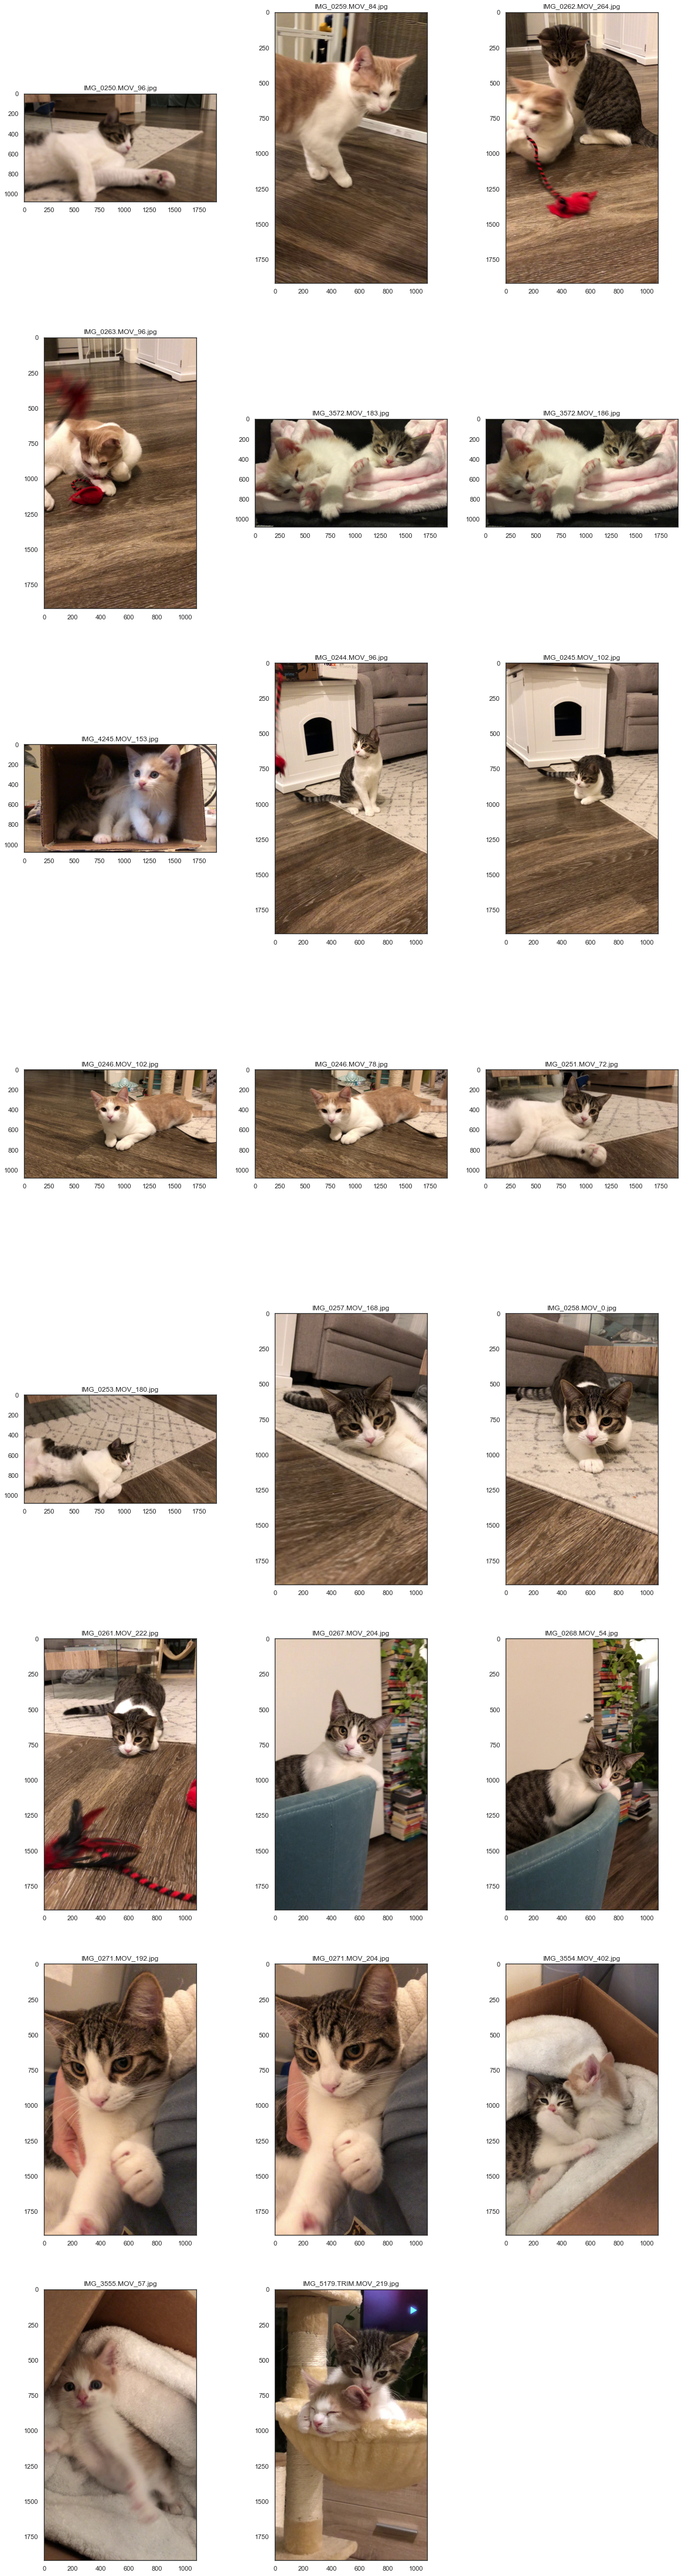

In [74]:
# Check the selected frame

import cv2 as cv

# Text parameters 
font = cv.FONT_HERSHEY_SIMPLEX
org = (800, 100)
fontScale = 2
color = (255, 0, 0)
thickness = 2

# List of lp_ratio
# lp_ratios = [round(x,4) for x in FP.lp_ratio.tolist()]

# Prepare list of best frames
selected_img = results.filename.tolist()
test_len = len(results)

# Plots
subplot_row = test_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(selected_img[:]):
    img = cv.imread('OpenCV_blur/frame_all_1/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()

### Check false positive images

In [75]:
# False-positive: bad photos but predicted to be good
FP = test_df[(test_df.label==0) & (test_df.pred==1)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

0

In [76]:
# False-positive: bad photos but predicted to be good
FP = results[(results.label==0)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

7

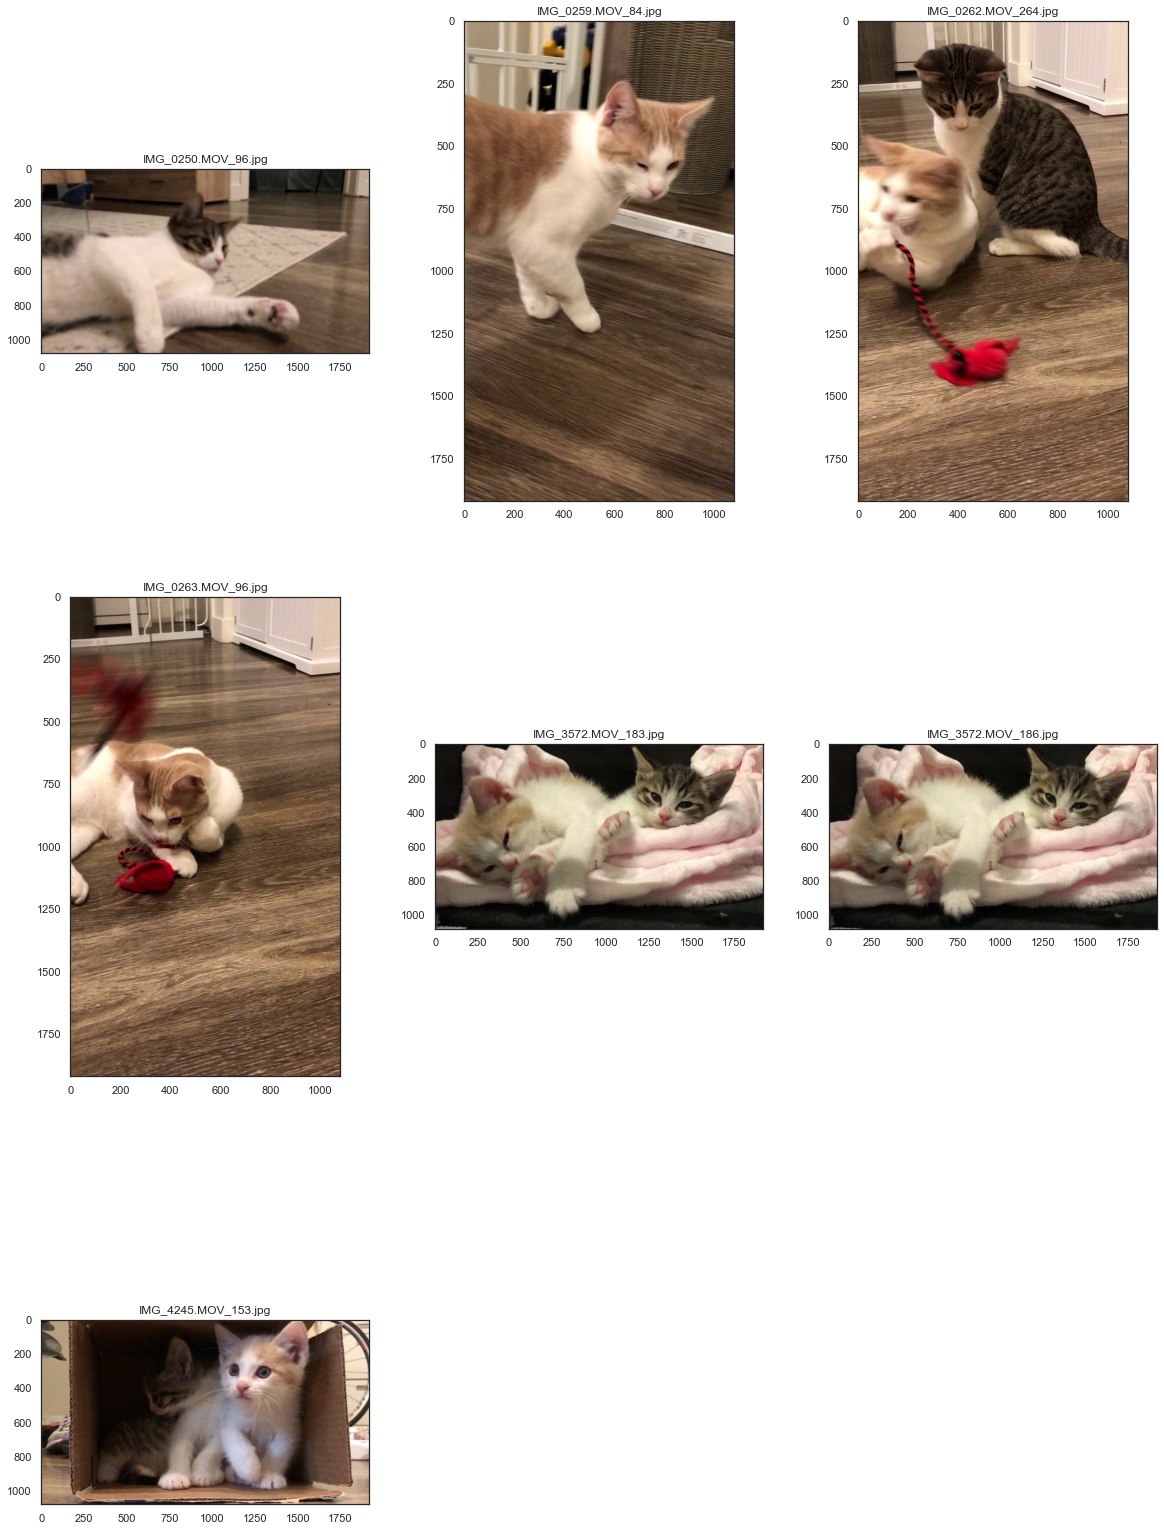

In [77]:
import cv2 as cv

# Plots
subplot_row = FP_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(FP_img[:]):
    img = cv.imread('OpenCV_blur/frame_all_1/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()

In [78]:
# Went back to check the images
# These are not great but indeed are the best among the given options